In [44]:
# Import necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix
    , accuracy_score, ConfusionMatrixDisplay
)
from sklearn.pipeline import Pipeline

import warnings 
warnings.simplefilter('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [45]:
# Download the NLTK dataset
nltk.download('movie_reviews')
from nltk.corpus import movie_reviews

# Load dataset into a DataFrame
docs = [(list(movie_reviews.words(fileid)), category)
        for category in movie_reviews.categories()
        for fileid in movie_reviews.fileids(category)]

df = pd.DataFrame(docs, columns=['review', 'sentiment'])

df.shape
df.head()

[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/t4ng0_br4v0/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


True

(2000, 2)

,review,sentiment
0,"[plot, :, two, teen, couples, go, to, a, churc...",neg
1,"[the, happy, bastard, ', s, quick, movie, revi...",neg
2,"[it, is, movies, like, these, that, make, a, j...",neg
3,"["", quest, for, camelot, "", is, warner, bros, ...",neg
4,"[synopsis, :, a, mentally, unstable, man, unde...",neg


In [46]:
df['sentiment'].value_counts()

sentiment
neg    1000
pos    1000
Name: count, dtype: int64

In [47]:
# Convert reviews to strings
df['review'] = df['review'].apply(lambda x: ' '.join(x))
df.head(3)

,review,sentiment
0,"plot : two teen couples go to a church party ,...",neg
1,the happy bastard ' s quick movie review damn ...,neg
2,it is movies like these that make a jaded movi...,neg


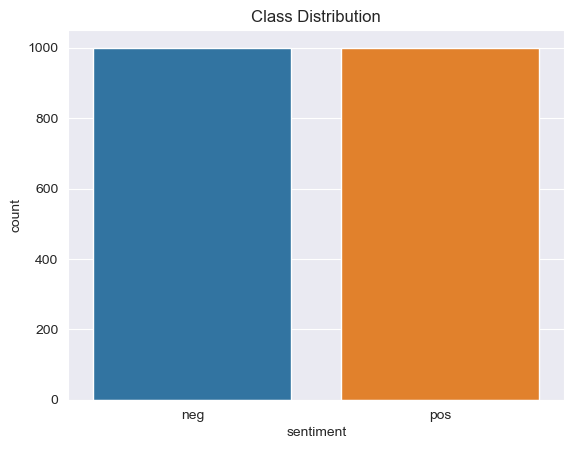

In [49]:
# EDA: Visualize class distribution

sns.set_style('darkgrid')

sns.countplot(
    data=df, x='sentiment')

plt.title("Class Distribution")
plt.show();

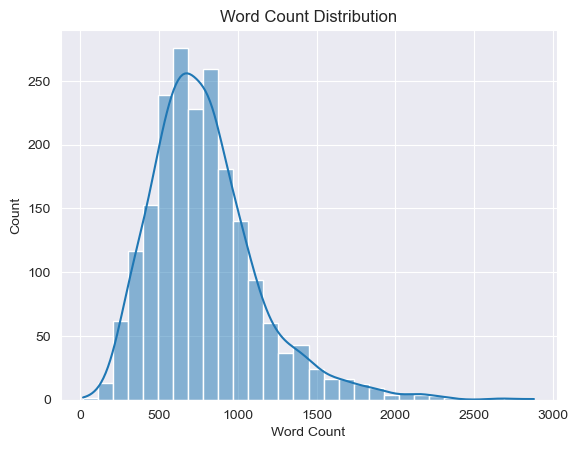

In [50]:
# EDA: Word count distribution
df['word_count'] = df['review'].apply(lambda x: len(x.split()))

sns.histplot(
    df['word_count']
    , bins=30, kde=True
)
plt.title("Word Count Distribution")
plt.xlabel("Word Count")
plt.show();

In [51]:
df.head()

,review,sentiment,word_count
0,"plot : two teen couples go to a church party ,...",neg,879
1,the happy bastard ' s quick movie review damn ...,neg,304
2,it is movies like these that make a jaded movi...,neg,581
3,""" quest for camelot "" is warner bros . ' first...",neg,629
4,synopsis : a mentally unstable man undergoing ...,neg,901


count    2000.000000
mean      791.910000
std       347.338096
min        19.000000
25%       560.000000
50%       745.000000
75%       957.250000
max      2879.000000
Name: word_count, dtype: float64

<Axes: >

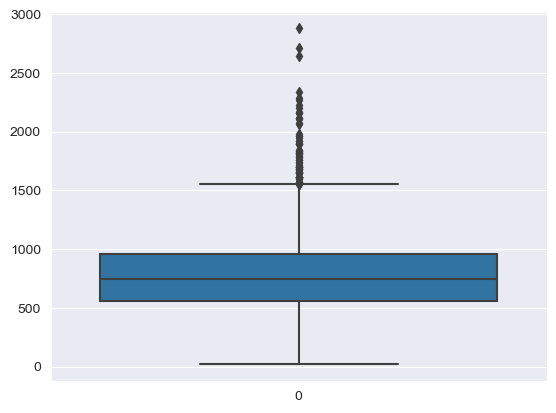

In [52]:
# Not needed but interesting ;) 
df['word_count'].describe().T

sns.boxplot(df['word_count'])

In [36]:
# Temporarily suppress duplicate outputs (have to do this w/ px otherwise, it will output dupe charts!)

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'last_expr'

# import plotly.express as px

In [90]:
# px.box(df['word_count'])

In [53]:
# Split data into features and labels
X = df['review']
y = df['sentiment']

X.shape, y.shape

((2000,), (2000,))

In [54]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=27
    , stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1600,), (400,), (1600,), (400,))

In [55]:
# Since we are going to give a few base models a runthrough to assess relative performance, will vectorize here (when we choose which model to run through the GridSearchCV, we will drop the tfidf into pipes;)

# Initialize TfidfVectorizer
tfidf = TfidfVectorizer(
    stop_words='english'
)

# Transform features
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

X_train_tfidf.shape, X_test_tfidf.shape
X_train_tfidf

((1600, 36121), (400, 36121))

<1600x36121 sparse matrix of type '<class 'numpy.float64'>'
	with 392895 stored elements in Compressed Sparse Row format>

In [56]:
# Initialize our base models for comparison:

models = {
    'MultinomialNB': MultinomialNB()
    , 'LogisticRegression': LogisticRegression(
        max_iter=1000, random_state=27)
    , 'SVC': SVC(random_state=27)
}

In [57]:
# Create a dictionary to store model names and accuracies
results = {}

# Evaluate models and store results
for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

# Convert the dictionary to a DataFrame
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy'])

results_df.sort_values(
    by='Accuracy', ascending=False, inplace=True
    )

# Display the DataFrame
display(results_df)

MultinomialNB()

LogisticRegression(max_iter=1000, random_state=27)

SVC(random_state=27)

,Model,Accuracy
1,LogisticRegression,0.8325
2,SVC,0.8275
0,MultinomialNB,0.8125


In [ ]:
# Original model fit & evaluate loop (commented out in favor of another option but preserving because I am not completely against using it or combining with this in the future...)

"""
# Build a for-loop so we can train and evaluate each model:

for name, model in models.items():
    
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    
    print(f"Model: {name}")
    print(classification_report(y_test, y_pred))
    print("=" * 50)
"""

In [58]:
# Select the best-performing model (e.g., LogisticRegression) for hyperparameter tuning
%timeit

selected_model = LogisticRegression(random_state=27)

# Set up GridSearchCV for hyperparameter tuning
param_grid = {
    'C': np.logspace(-4, 2, 13) # [0.0001, 0.0003162, 0.001, ... 10.0, 31.62, 100.0]
    , 'solver': ['liblinear', 'lbfgs']
}

grid_search = GridSearchCV(
    estimator=selected_model
    , param_grid=param_grid
    , scoring='accuracy'
    , cv=5
)

In [59]:
%time

# Perform grid search
grid_search.fit(X_train_tfidf, y_train)

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 16.9 µs


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=27),
             param_grid={'C': array([1.00000000e-04, 3.16227766e-04, 1.00000000e-03, 3.16227766e-03,
       1.00000000e-02, 3.16227766e-02, 1.00000000e-01, 3.16227766e-01,
       1.00000000e+00, 3.16227766e+00, 1.00000000e+01, 3.16227766e+01,
       1.00000000e+02]),
                         'solver': ['liblinear', 'lbfgs']},
             scoring='accuracy')

In [60]:
print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

Best Parameters: {'C': 31.622776601683793, 'solver': 'liblinear'}


In [80]:
from sklearn.metrics import (
    confusion_matrix
    , classification_report 
    , ConfusionMatrixDisplay 
    , roc_auc_score 
    , RocCurveDisplay 
    , PrecisionRecallDisplay )

In [63]:
best_model.fit(X_train_tfidf, y_train)
best_model.score(X_test_tfidf, y_test)

LogisticRegression(C=31.622776601683793, random_state=27, solver='liblinear')

0.865

In [66]:
print(f"Best Model vs. Base Model (LogReg) : {np.round(((best_model.score(X_test_tfidf, y_test) - results_df.iloc[0][1])*100), 4)} %")

Best Model vs. Base Model (LogReg) : 3.25 %


In [70]:
# Fitting and scoring the base for comparison to best;
selected_model.fit(X_train_tfidf, y_train)
selected_model.score(X_test_tfidf, y_test)

LogisticRegression(random_state=27)

0.8325

In [72]:
# See how the best boosted model does on test data:

# Predict on test set
y_pred = best_model.predict(X_test_tfidf)
score_best = accuracy_score(y_test, y_pred)
score_best


# Eval performance of base to see how much better the 'best_model' is;
y_pred_base = selected_model.predict(X_test_tfidf)
score_base = accuracy_score(y_test, y_pred_base)
score_base

0.865

0.8325

In [73]:
# Comparison of CMs (tex/array, non-viz) for Best vs. Base:

print("Confusion Matrix, Best Model:")
confusion_matrix(y_test, y_pred)
print('\n')
print("Confusion Matrix, Base Model:")
confusion_matrix(y_test, y_pred_base)

Confusion Matrix, Best Model:


array([[172,  28],
       [ 26, 174]])



Confusion Matrix, Base Model:


array([[165,  35],
       [ 32, 168]])

In [74]:
# Comparison of classification reports for Best vs. Base:

print("Classification Report, Best Model:")
print(classification_report(y_test, y_pred))
print('\n')
print("Classification Report, Base Model:")
print(classification_report(y_test, y_pred_base))

Classification Report, Best Model:
              precision    recall  f1-score   support

         neg       0.87      0.86      0.86       200
         pos       0.86      0.87      0.87       200

    accuracy                           0.86       400
   macro avg       0.87      0.86      0.86       400
weighted avg       0.87      0.86      0.86       400



Classification Report, Base Model:
              precision    recall  f1-score   support

         neg       0.84      0.82      0.83       200
         pos       0.83      0.84      0.83       200

    accuracy                           0.83       400
   macro avg       0.83      0.83      0.83       400
weighted avg       0.83      0.83      0.83       400



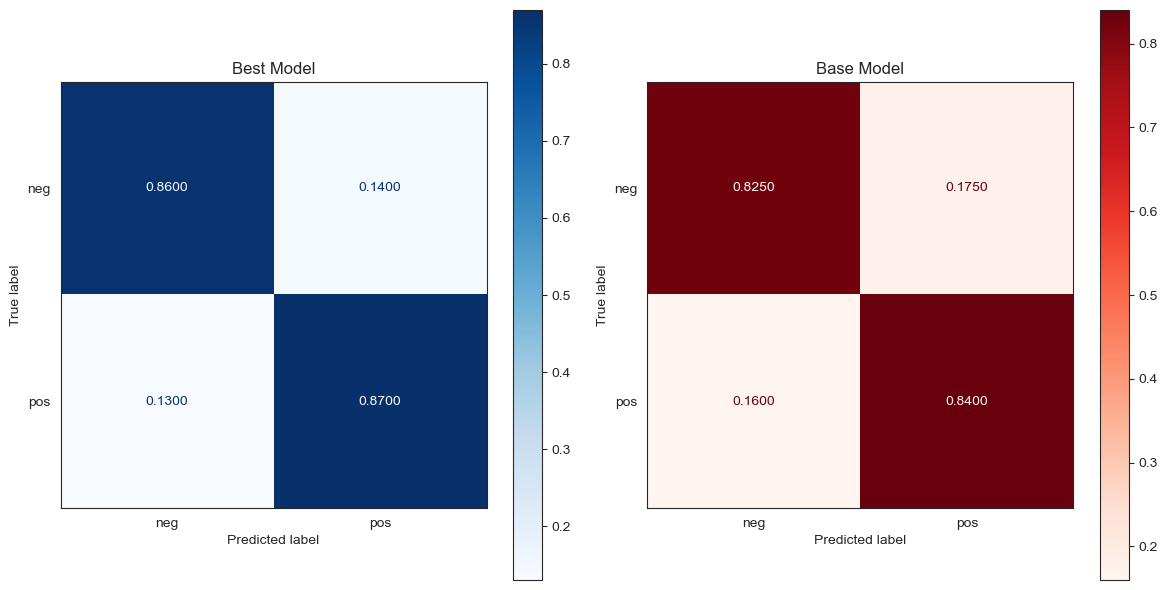

In [77]:
# To do a side-by-side, normalized CM comparison (Best vs. Base):

sns.set_style('white')

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ConfusionMatrixDisplay.from_estimator(
    best_model, X_test_tfidf, y_test, normalize='true', cmap='Blues', values_format='.4f'
    , ax=ax[0]
)

ConfusionMatrixDisplay.from_estimator(
    selected_model, X_test_tfidf, y_test, normalize='true', cmap='Reds', values_format='.4f'
    , ax=ax[1]
)

ax[0].set_title('Best Model')
ax[1].set_title('Base Model')

plt.tight_layout()
plt.show();

In [78]:
# Back to darkgrid for the curveplots bc it just looks nicer ;)
plt.style.use('seaborn-v0_8-darkgrid')

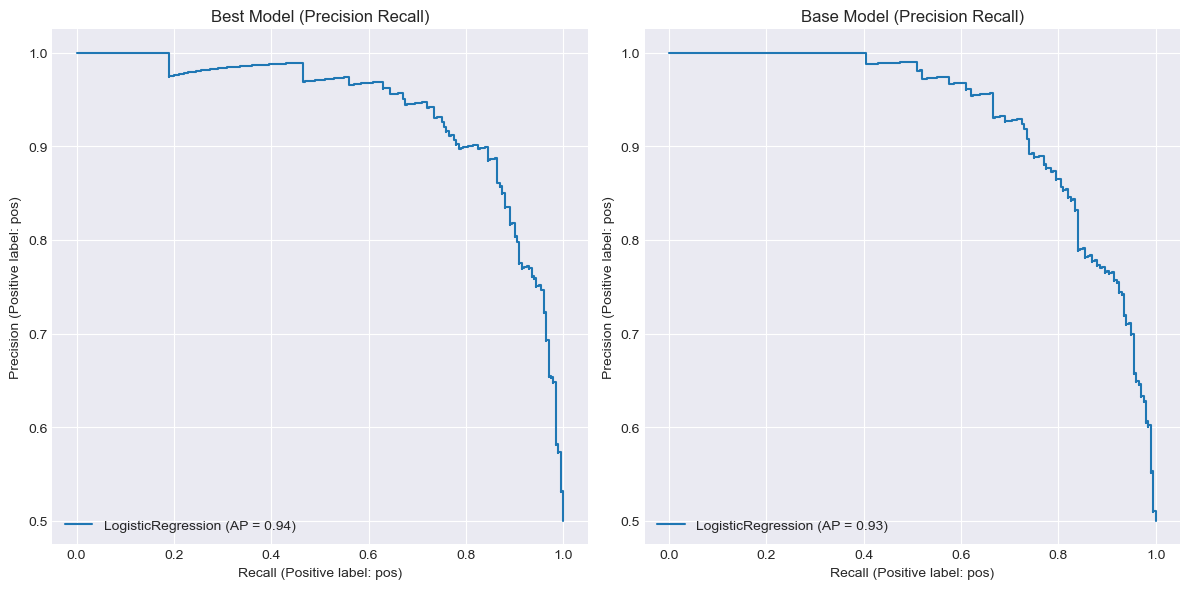

In [81]:
# To do a side-by-side, numerical Precision Recall comparison (Best vs. Base):

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

PrecisionRecallDisplay.from_estimator(
    best_model, X_test_tfidf, y_test, ax=ax[0]
)

PrecisionRecallDisplay.from_estimator(
    selected_model, X_test_tfidf, y_test, ax=ax[1]
)

ax[0].set_title('Best Model (Precision Recall)')
ax[1].set_title('Base Model (Precision Recall)')

plt.tight_layout()
plt.show();

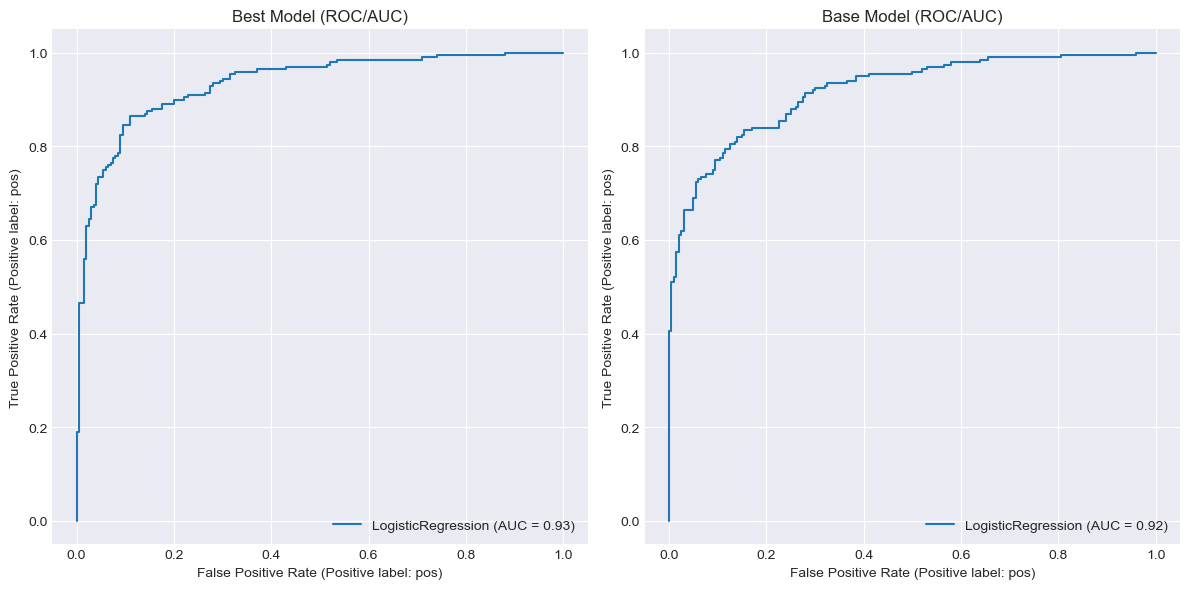

In [82]:
# To do a side-by-side, numerical Precision Recall comparison (Best vs. Base):

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

RocCurveDisplay.from_estimator(
    best_model, X_test_tfidf, y_test, ax=ax[0]
)

RocCurveDisplay.from_estimator(
    selected_model, X_test_tfidf, y_test, ax=ax[1]
)

ax[0].set_title('Best Model (ROC/AUC)')
ax[1].set_title('Base Model (ROC/AUC)')

plt.tight_layout()
plt.show();

In [85]:
# Temporarily suppress duplicate outputs (have to do this w/ px otherwise, it will output dupe charts!)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'last_expr'

In [86]:
import plotly.express as px

cm = confusion_matrix(y_test, y_pred_final)

cm_df = pd.DataFrame(cm)
cm_df

,0,1
0,172,28
1,26,174


In [87]:
px.imshow(
    cm_df, text_auto=True  # Automatically adds text annotations
    , color_continuous_scale='Blues'
    , labels=dict(
#         x="Predicted", y="Actual", 
        color="Count")
    , title="Confusion Matrix")

In [88]:
# Bonus - set up a 'normalized' CM in px - extra bonus: with the actal cm col headers;

cm_normd = confusion_matrix(y_test, y_pred_final, normalize='true')
cm_normd

cm_normd_df = pd.DataFrame(
    cm_normd
    , columns=["Predicted Negative", "Predicted Positive"]
    , index=["Actual Negative", "Actual Positive"]
)
cm_normd_df

,Predicted Negative,Predicted Positive
Actual Negative,0.86,0.14
Actual Positive,0.13,0.87


In [89]:
px.imshow(
    cm_normd_df, text_auto=True  # Automatically adds text annotations
    , color_continuous_scale='Blues'
    , labels=dict(
        color="Count")
    , title="Confusion Matrix")